In [1]:
import matplotlib.pyplot as plt
import requests
import numpy as np
import pandas as pd
import pandas_ta as ta
from datetime import datetime
from binance.client import Client
client = Client()

from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFE
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFE
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

import pickle
import pathlib

In [2]:
def func_model_performance(df,testDate,risk_free):
    #функция расчета метрик кечества

    df['pnl_cumsum'] = df['pnl'].cumsum()
    df['pnl_cumsum_max'] = df['pnl_cumsum'].cummax()
    df['pnl_dd'] = df['pnl_cumsum_max'] - df['pnl_cumsum']

    full = df
    train = df[(df.index<testDate)].reindex()
    test = df[(df.index>=testDate)].reindex()

    pnl_full  = round(full['pnl'].sum() ,6)
    pnl_train = round(train['pnl'].sum(),6)
    pnl_test  = round(test['pnl'].sum() ,6)
    
    delta = full.index.max() - full.index.min()
    annual_yield_full  = round(pnl_full/delta.days*365*100 ,2)
    delta = train.index.max() - train.index.min()
    annual_yield_train = round(pnl_train/delta.days*365*100,2)
    delta = test.index.max() - test.index.min()
    annual_yield_test  = round(pnl_test/delta.days*365*100 ,2)

    mdd_full = round(full['pnl_dd'].max()  ,6)
    mdd_train = round(train['pnl_dd'].max(),6)
    mdd_test = round(test['pnl_dd'].max()  ,6)
    
    sharpe_full  = round( ((np.mean(full['pnl'])  * 60 * 24 * 365) - risk_free) / (np.std(full['pnl'])  * np.sqrt(60 * 24 * 365)) ,6)
    sharpe_train = round( ((np.mean(train['pnl']) * 60 * 24 * 365) - risk_free) / (np.std(train['pnl']) * np.sqrt(60 * 24 * 365)) ,6)
    sharpe_test  = round( ((np.mean(test['pnl'])  * 60 * 24 * 365) - risk_free) / (np.std(test['pnl'])  * np.sqrt(60 * 24 * 365)) ,6)

    print('           full       train      test')
    print('PNL      : {0: <10}'.format(pnl_full),'{0: <10}'.format(pnl_train),'{0: <10}'.format(pnl_test))
    print('MDD      : {0: <10}'.format(mdd_full),'{0: <10}'.format(mdd_train),'{0: <10}'.format(mdd_test))
    print('Sharpe   : {0: <10}'.format(sharpe_full),'{0: <10}'.format(sharpe_train),'{0: <10}'.format(sharpe_test))
    print('Yield    : {0: <6}%   '.format(annual_yield_full),'{0: <6}%   '.format(annual_yield_train),'{0: <6}%  '.format(annual_yield_test))
    
    target = sharpe_train
    return target

def func_plot(df):
    #функция графика PNL
    df['pnl_cumsum'] = df['pnl'].cumsum()
    df['pnl_cumsum_max'] = df['pnl_cumsum'].cummax()
    df['pnl_dd'] = df['pnl_cumsum_max'] - df['pnl_cumsum']
    plt.figure(figsize=(20,7))
    plt.plot(df['pnl_cumsum'],color='black')
    plt.plot(df['pnl_cumsum_max'],color='red')
    plt.axvline(x = pd.to_datetime(testDate), color='black')
    plt.grid()
    plt.show()
    
def func_features(df):
    # цункция генерации фичей
    
    for length in [6,12,16,20,25,30,50, 60, 80]:
        df.ta(kind='SMA',append=True,centered=False,close='openPrice',length=length)
        df[f'f_SMA_{length}'] = np.where(df['closePrice']>df[f'SMA_{length}'],-1,1)

        df[f'f_trend_{length}'] = np.where(df['return'].shift(1).rolling(window=length).sum()>0,-1,1)

        df.ta(kind='ATR',append=True,centered=False,high='highPrice',low='lowPrice',volume='volume',close='closePrice',length=length)
        df[f'f_ATR_{length}'] = np.where(df[f'ATRr_{length}']>df[f'ATRr_{length}'].rolling(window=6).mean(),1,-1)

        df.ta(kind='RSI',append=True,centered=False,close='closePrice',length=length)
        df['f_rsi'] = np.where(df[f'RSI_{length}']<20,1,np.where(df[f'RSI_{length}']>80,-1,0))

        df.ta(kind='PVT',append=True,centered=False,volume='volume',close='closePrice')
        df['f_pvt'] = np.where(df['PVT']>df['PVT'].rolling(window=length).mean(),1,-1)

    df.ta(kind='MACD',append=True,centered=False,high='highPrice',low='lowPrice',volume='volume',close='closePrice',length=6)
    df['f_macd'] = np.where(df[f'MACDh_12_26_9']>0,1,-1)

    df['f_ao'] = ta.ao(df['highPrice'], df['lowPrice'])
    df['f_sma_ao'] = ta.sma(df['f_ao'], length=5)
    df['f_ac'] = df['f_ao'] - df['f_sma_ao']
    df['f_a_jaw'] = ((df['highPrice'] + df['lowPrice'])/2).rolling(window=13).mean().shift(8)
    df['f_a_teeth'] = ((df['highPrice'] + df['lowPrice'])/2).rolling(window=8).mean().shift(5)
    df['f_a_lips'] = ((df['highPrice'] + df['lowPrice'])/2).rolling(window=5).mean().shift(3)
    df['f_apo'] = ta.apo((df['highPrice'] + df['lowPrice'])/2)
    df = pd.concat([df, ta.aroon(df['highPrice'], df['lowPrice'], length=20)], axis=1)
    df['f_atr'] = ta.atr(df['highPrice'], df['lowPrice'], df['closePrice'])
    df = pd.concat([df, ta.bbands(df['closePrice'], length=14)], axis=1)
    df = pd.concat([df, ta.ichimoku(df['highPrice'], df['lowPrice'], df['closePrice'])[0]], axis=1)
    df['f_cmo'] = ta.cmo(df['closePrice'], length=19)
    df['f_chaikin'] = ta.cmf(df['highPrice'], df['lowPrice'], df['closePrice'], df['volume'])

    df.ta(kind='OBV',append=True,centered=False,high='highPrice',low='lowPrice',volume='volume',close='closePrice',length=6)
    df[f'f_OBV'] = np.where(df['OBV']<df['OBV'].rolling(window=12).mean(),-1,1)
    
    df.replace([np.inf, -np.inf], 0, inplace=True)
    df = df.fillna(0)
    return df

In [3]:
# загрузка данных
symbol = 'BTCUSDT'
risk_free = 0
testDate = '2024-11-01 00:00:00'
df_start_time = '2024-11-01 00:00:00'
df_end_time = '2025-01-01 00:00:00'
candles_path = pathlib.Path('candles') / symbol
if candles_path.with_suffix('.csv').is_file():
    df = pd.read_csv(candles_path.with_suffix('.csv'), index_col=0)
    df['return'] = ((df['closePrice'] - df['openPrice']) / df['openPrice'] )
    df['return_next'] = df['return'].shift(-1).fillna(0)
    df['target'] = df['return'].shift(-1).fillna(0)
    df['position'] = 1
    df['pnl'] = df['position'] * df['target']
    df.index = pd.to_datetime(df.index)
    df = df.astype({'closePrice':'float','openPrice':'float','highPrice':'float','lowPrice':'float','volume':'float'})
else:
    print('no')

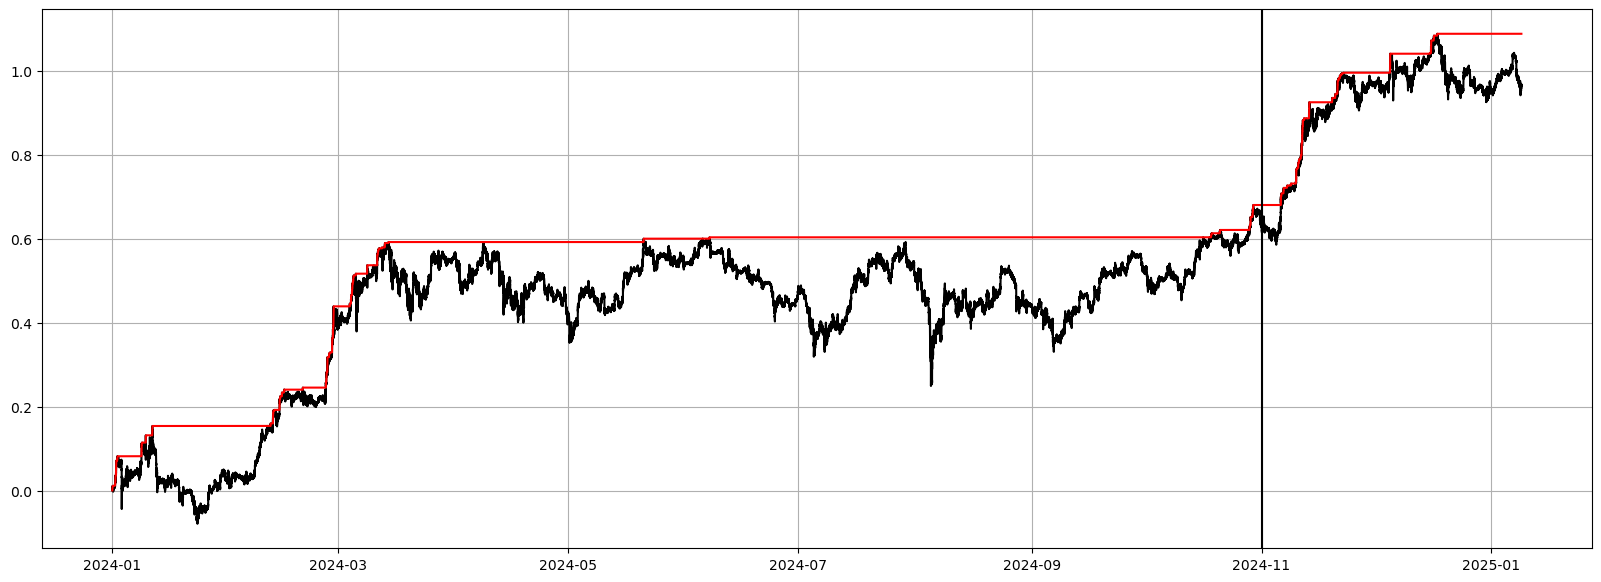

           full       train      test
PNL      : 0.965599   0.635542   0.330057  
MDD      : 0.354059   0.354059   0.162871  
Sharpe   : 1.706496   1.375101   3.184165  
Yield    : 94.49 %    76.31 %    177.16%  


In [4]:
# стратегия buy&hold
func_plot(df)
target = func_model_performance(df,testDate,risk_free)

In [5]:
# генерация фичей
df = func_features(df)
features = [col for col in df if col.startswith('f_')]
df[features] = df[features].fillna(0)
# разбиение train / test
train = df[(df.index<testDate)].fillna(0).reindex()
test = df[(df.index>=testDate)].fillna(0).reindex()
X_train = train[features]
X_test = test[features]
y_train = train['target']
y_test = test['target']

In [6]:
from sklearn.metrics import make_scorer

def sharpe_ratio(y_true, y_pred):
    """
    Вычисляет коэффициент Шарпа.
    :param y_true: Истинные значения (не обязательно используются в данном контексте).
    :param y_pred: Предсказания модели.
    :return: Значение коэффициента Шарпа.
    """
    y_position = np.where(y_pred > 0, 1, -1)
    pnl = y_position*y_true
    mean_pnl = np.mean(pnl)  # Средний доход
    std_pnl = np.std(pnl)   # Стандартное отклонение доходов

    # Коэффициент Шарпа
    sharpe = round(((mean_pnl * 60 * 24 * 365) - risk_free) / (std_pnl * np.sqrt(60 * 24 * 365)), 6)
    return sharpe

sharpe_scorer = make_scorer(sharpe_ratio, greater_is_better=True)

In [7]:
from sklearn.metrics import make_scorer

def accuracy(y_true, y_pred):
    """
    Вычисляет коэффициент Шарпа.
    :param y_true: Истинные значения (не обязательно используются в данном контексте).
    :param y_pred: Предсказания модели.
    :return: Значение коэффициента Шарпа.
    """
    y_position0 = np.where(y_pred > 0, 0, -1)
    y_position1 = np.where(y_pred > 0, 1, 0)
    return (np.where(y_true>0,1,0)*y_position1 + np.where(y_true>0,0,-1)*y_position0).sum()/len(y_position0)

accuracy_scorer = make_scorer(accuracy, greater_is_better=True)

In [8]:
import optuna
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split


X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size=0.3, shuffle=False) #,  random_state=2021
# Целевая функция для Optuna
def objective(trial):
    # Выбираем модель: Ridge, Lasso или ElasticNet
    model_type = trial.suggest_categorical("model_type", ["Ridge", "Lasso", "ElasticNet"])
    
    # Параметры регуляризации
    alpha = trial.suggest_float("alpha", 1e-4, 1e1)  # Коэффициент регуляризации, log-uniform для широкой шкалы
    fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])  # Включение свободного члена
    
    # Параметры сходимости
    max_iter = trial.suggest_int("max_iter", 1000, 5000, step=500)  # Количество итераций
    tol = trial.suggest_float("tol", 1e-5, 1e-2)  # Точность сходимости
    # Для ElasticNet добавляем параметр l1_ratio
    if model_type == "ElasticNet":
        l1_ratio = trial.suggest_float("l1_ratio", 0, 1)  # Пропорция L1 и L2 регуляризации
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=fit_intercept, 
                           max_iter=max_iter, tol=tol)
    elif model_type == "Ridge":
        model = Ridge(alpha=alpha, fit_intercept=fit_intercept, max_iter=max_iter, tol=tol)
    else:  # Lasso
        model = Lasso(alpha=alpha, fit_intercept=fit_intercept, max_iter=max_iter, tol=tol)
    
    # Оценка модели с использованием кросс-валидации
    model.fit(X_train1, y_train1)
    y_pred = model.predict(X_test1)
    return sharpe_ratio(y_test1, y_pred)

# Запуск Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Лучшие параметры
print("Best hyperparameters:", study.best_params)
print(f"Лучший результат: {study.best_value}")

[I 2025-03-25 16:05:07,209] A new study created in memory with name: no-name-a713d23d-dece-4753-828e-6358558ac4c3
[I 2025-03-25 16:05:07,330] Trial 0 finished with value: -0.901016 and parameters: {'model_type': 'ElasticNet', 'alpha': 3.873784018512274, 'fit_intercept': False, 'max_iter': 4000, 'tol': 0.006039912857408343, 'l1_ratio': 0.7932453408952794}. Best is trial 0 with value: -0.901016.
[I 2025-03-25 16:05:07,434] Trial 1 finished with value: 2.975953 and parameters: {'model_type': 'Ridge', 'alpha': 1.9169802820873618, 'fit_intercept': True, 'max_iter': 1000, 'tol': 0.006453449736737909}. Best is trial 1 with value: 2.975953.
[I 2025-03-25 16:05:07,532] Trial 2 finished with value: 0.901016 and parameters: {'model_type': 'ElasticNet', 'alpha': 0.9665802279174852, 'fit_intercept': True, 'max_iter': 4000, 'tol': 0.007620132884355715, 'l1_ratio': 0.438794245202223}. Best is trial 1 with value: 2.975953.
[I 2025-03-25 16:05:07,612] Trial 3 finished with value: -0.901016 and paramete

Best hyperparameters: {'model_type': 'Ridge', 'alpha': 0.21894464275829717, 'fit_intercept': False, 'max_iter': 3000, 'tol': 0.009907088106412401}
Лучший результат: 4.589029


In [9]:
params = study.best_params
del params['model_type']

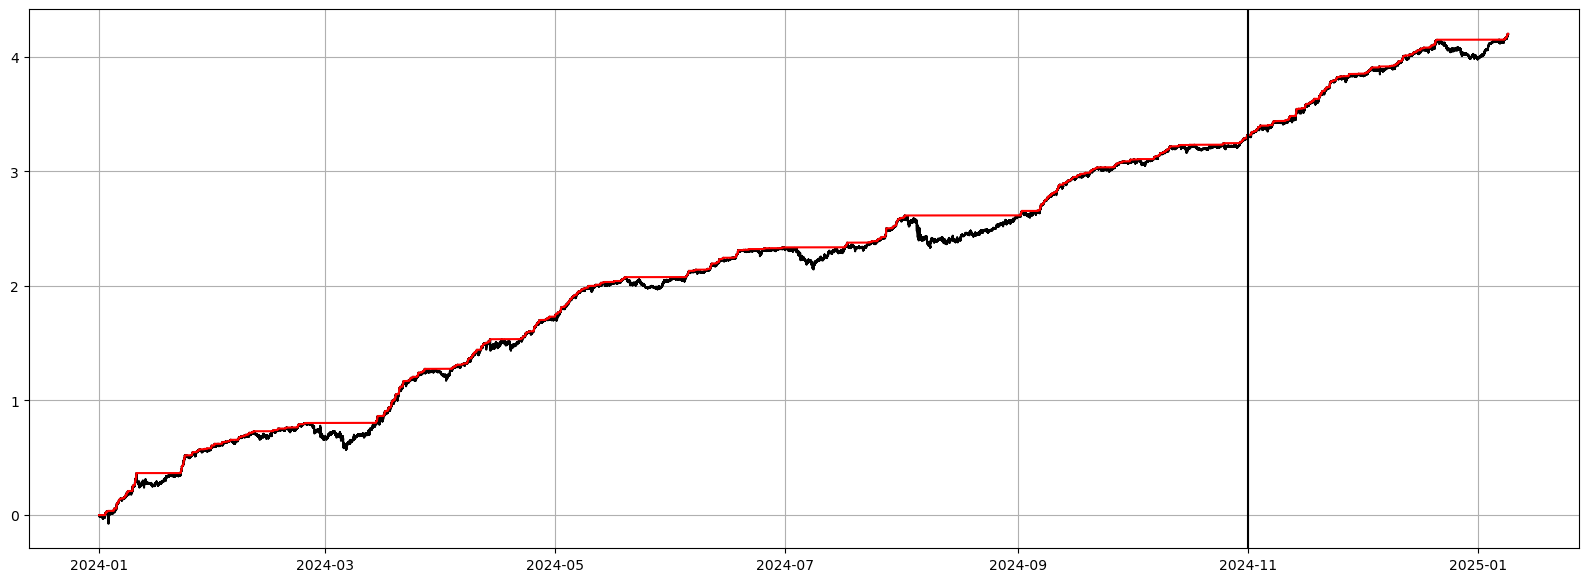

           full       train      test
PNL      : 4.199442   3.313053   0.886389  
MDD      : 0.281162   0.281162   0.170786  
Sharpe   : 7.422009   7.168679   8.551786  
Yield    : 410.94%    397.78%    475.78%  


In [10]:
# обучение модели
model = Ridge(**params)
#model = LinearRegression()
model.fit(X_train, y_train)
# предсказание
df['predict'] = model.predict(df[features])
df['position'] = np.where(df['predict']>0,1,-1)
df['pnl'] = df['position'] * df['return_next']
# результат
func_plot(df)
target = func_model_performance(df,testDate,risk_free)

Результат превосходит бейзлайн, где шарп на тесте был 6.042321, а на трейне 6.79

Достигнуто за счёт оптимизации гиперпараметров и добавления новых фичей